# PUMP IT UP


**Introduction:**
Using the data gathered from Taarifa and the Tanzanian Ministry of Water, can we predict which pumps are functional, which need some repairs, and which don't work at all? Predicting one of these three classes based and a smart understanding of which waterpoints will fail, can improve the maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

This is also an intermediate-level competition by [DataDriven][1]! All code & support scripts are in [Github Repo][2]

[1]: https://www.drivendata.org/competitions/7/ "Link to Competetion Page"
[2]: https://github.com/msampathkumar/datadriven_pumpit "User Code"

# Imports

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
# %load_ext writeandexecute

plt.style.use('ggplot')
sns.set(color_codes=True)

# seed
np.random.seed(69572)

In [2]:
# import sys
# sys.path = sys.path + ['/Users/sampathkumarm/Desktop/devbox/Sam-DS/Kaggle/datadriven']

import scripts

import imp
imp.reload(scripts)

from scripts.sam_value_counts import sam_dataframe_cols_value_count_analysis, sam_dataframe_markup_value_counts
from scripts.sam_confusion_matrix import sam_plot_confusion_matrix, sam_confusion_maxtrix

In [3]:
import sys

from __future__ import absolute_import
from IPython.core.getipython import get_ipython
from IPython.core.magic import (Magics, magics_class,  cell_magic)

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

from markdown import markdown
from IPython.core.display import HTML
from IPython.display import display

@magics_class
class MarkdownMagics(Magics):
 
    @cell_magic
    def asmarkdown(self, line, cell):
        buffer = StringIO()
        stdout = sys.stdout
        sys.stdout = buffer
        try:
            exec(cell, locals(), self.shell.user_ns)
        except:
            sys.stdout = stdout
            raise
        sys.stdout = stdout
        return HTML("<p>{}</p>".format(markdown(buffer.getvalue(), extensions=['markdown.extensions.extra'])))
        return buffer.getvalue() + 'test'
    
    def timer_message(self, start_time):
#         print self
        time_diff = (now() - start_time).total_seconds()
        if time_diff < 0.001:
            time_diff = 0
            print('\n<pre>In', time_diff, 'Secs</pre>')
        else:
            print('\n<pre>In', time_diff, 'Secs</pre>')

    @cell_magic
    def timer(self, line, cell):
        import datetime
        now = datetime.datetime.now
        start_time = now()
        buffer = StringIO()
        stdout = sys.stdout
        sys.stdout = buffer
        try:
            exec(cell, locals(), self.shell.user_ns)
            self.timer_message(start_time)
        except:
            sys.stdout = stdout
            raise
        sys.stdout = stdout
        return HTML("<p>{}</p>".format(markdown(buffer.getvalue(), extensions=['markdown.extensions.extra'])))
        return buffer.getvalue() + 'test'
 
get_ipython().register_magics(MarkdownMagics)

# Data Analysis

In [4]:
RAW_X = pd.read_csv('data/traning_set_values.csv', index_col='id')
RAW_y = pd.read_csv('data/training_set_labels.csv', index_col='id')
RAW_TEST_X = pd.read_csv('data/test_set_values.csv', index_col='id')

In [5]:
print('Shape of RAW_X', RAW_X.shape)
print('Shape of RAW_y', RAW_y.shape)
print('Shape of RAW_TEST_X', RAW_TEST_X.shape)

# ('Shape of RAW_X', (59400, 39))
# ('Shape of RAW_y', (59400, 1))
# ('Shape of RAW_TEST_X', (14850, 39))

Shape of RAW_X (59400, 39)
Shape of RAW_y (59400, 1)
Shape of RAW_TEST_X (14850, 39)


In [6]:
for i, col in enumerate(RAW_X.columns):
    print('|%d|%s|%d|' % (i, col, len(RAW_X[col].value_counts())))

|0|amount_tsh|98|
|1|date_recorded|356|
|2|funder|1897|
|3|gps_height|2428|
|4|installer|2145|
|5|longitude|57516|
|6|latitude|57517|
|7|wpt_name|37400|
|8|num_private|65|
|9|basin|9|
|10|subvillage|19287|
|11|region|21|
|12|region_code|27|
|13|district_code|20|
|14|lga|125|
|15|ward|2092|
|16|population|1049|
|17|public_meeting|2|
|18|recorded_by|1|
|19|scheme_management|12|
|20|scheme_name|2696|
|21|permit|2|
|22|construction_year|55|
|23|extraction_type|18|
|24|extraction_type_group|13|
|25|extraction_type_class|7|
|26|management|12|
|27|management_group|5|
|28|payment|7|
|29|payment_type|7|
|30|water_quality|8|
|31|quality_group|6|
|32|quantity|5|
|33|quantity_group|5|
|34|source|10|
|35|source_type|7|
|36|source_class|3|
|37|waterpoint_type|7|
|38|waterpoint_type_group|6|


In [7]:
# integer colums
cols_ints = '''amount_tsh
gps_height
longitude
latitude
num_private
region_code
district_code
population
construction_year'''.splitlines()

# bool
cols_bool = 'public_meeting permit'.split()

# date
cols_date = ['date_recorded']

print('INT COlS: ', len(cols_ints))
print('BOOL COLS:', len(cols_bool))
print('Date COLS:', len(cols_date))

INT COlS:  9
BOOL COLS: 2
Date COLS: 1


In [8]:
len(RAW_X.columns)

39

In [9]:
def show_object_dtypes(df,others=True):
    dtype = object
    if others:
        return df.dtypes[df.dtypes == dtype]
    else:
        return df.dtypes[df.dtypes != dtype]

In [10]:
show_object_dtypes(RAW_TEST_X, True)

date_recorded            object
funder                   object
installer                object
wpt_name                 object
basin                    object
subvillage               object
region                   object
lga                      object
ward                     object
public_meeting           object
recorded_by              object
scheme_management        object
scheme_name              object
permit                   object
extraction_type          object
extraction_type_group    object
extraction_type_class    object
management               object
management_group         object
payment                  object
payment_type             object
water_quality            object
quality_group            object
quantity                 object
quantity_group           object
source                   object
source_type              object
source_class             object
waterpoint_type          object
waterpoint_type_group    object
dtype: object

In [11]:
show_object_dtypes(RAW_TEST_X, False)

amount_tsh           float64
gps_height             int64
longitude            float64
latitude             float64
num_private            int64
region_code            int64
district_code          int64
population             int64
construction_year      int64
dtype: object

### cols_values_counts_dataframe

As we can see in above *describe* output, we seem to have lots of categorical values so let start exploring them a bit.

Lets start taking into believe everything is a Categorical Columns and check their data

In [12]:
columns = RAW_X.columns
values_counts_bag = [len(RAW_X[column].value_counts()) for column in columns]

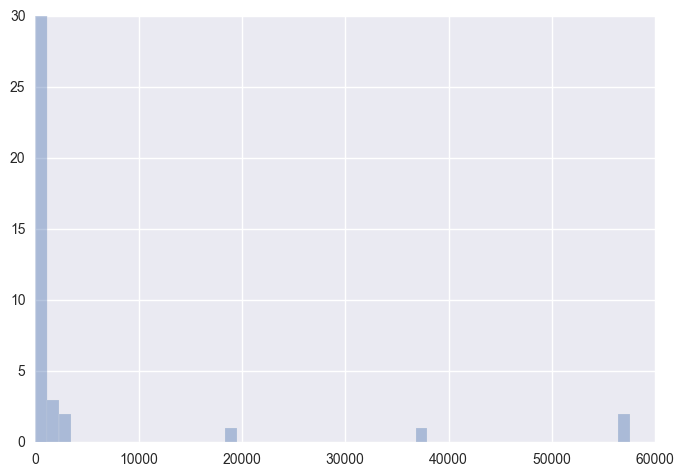

In [13]:
_ = sns.distplot(values_counts_bag, hist=True, kde=False,)

** Example of how np-log transforms data**

    >>> np.log([0.001, 0.01, 0.1, 1, 10, 100, 1000])

    array([-6.90775528, -4.60517019, -2.30258509,  0.        ,  2.30258509,
            4.60517019,  6.90775528])

As you can see in np-log example, we can learn that when a list of values vary significantly(exponentially) then their logarithms moves linearly. As we(I) feel comfortable in studying linear plot and linear information, we did a np.log to values counts.

In [14]:
cols_values_counts_dataframe = pd.DataFrame(np.log(values_counts_bag), index=columns, columns=['Value Counts'])

Values Counts: [98, 356, 1897, 2428, 2145, 57516, 57517, 37400, 65, 9, 19287, 21, 27, 20, 125, 2092, 1049, 2, 1, 12, 2696, 2, 55, 18, 13, 7, 12, 5, 7, 7, 8, 6, 5, 5, 10, 7, 3, 7, 6]

Log of Values Counts: [[  4.58496748   5.87493073   7.54802897   7.79482315   7.67089483
   10.95981845  10.95983584  10.52942598   4.17438727   2.19722458
    9.86718657   3.04452244   3.29583687   2.99573227   4.82831374
    7.64587583   6.95559261   0.69314718   0.           2.48490665
    7.89952447   0.69314718   4.00733319   2.89037176   2.56494936
    1.94591015   2.48490665   1.60943791   1.94591015   1.94591015
    2.07944154   1.79175947   1.60943791   1.60943791   2.30258509
    1.94591015   1.09861229   1.94591015   1.79175947]]


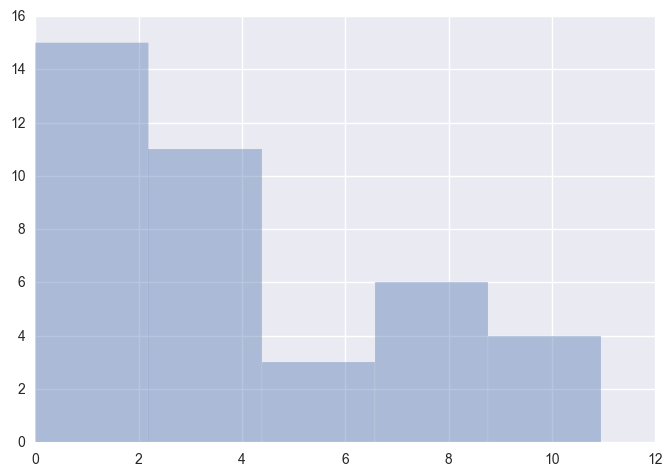

In [15]:
print('Values Counts:', values_counts_bag)

print('\nLog of Values Counts:', cols_values_counts_dataframe.T.values)

_ = sns.distplot(cols_values_counts_dataframe.T.values, hist=True, kde=False,)

We seem to have some special categories where value counts are high.


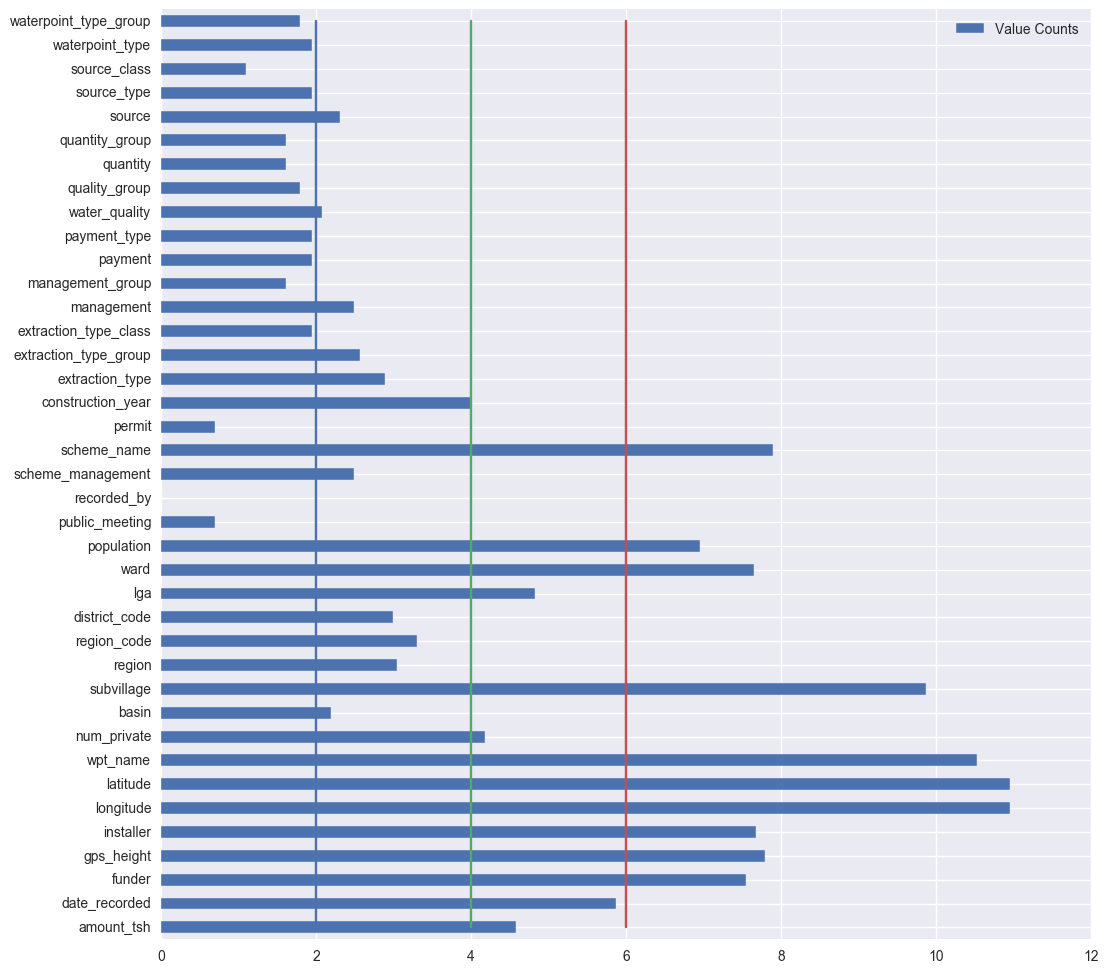

In [16]:
cols_values_counts_dataframe.plot(kind='barh', figsize=(12, 12))
_ = plt.plot((2, 2), (0, 38))
_ = plt.plot((4, 4), (0, 38), '-g')
_ = plt.plot((6, 6), (0, 38), '-r')
print('We seem to have some special categories where value counts are high.')

(1, 'waterpoint_type_group', 24)
(2, 'basin', 24)
(3, 'region', 24)
(4, 'region_code', 24)
(5, 'district_code', 24)
(6, 'public_meeting', 24)
(7, 'recorded_by', 24)
(8, 'scheme_management', 24)
(9, 'permit', 24)
(10, 'extraction_type', 24)
(11, 'extraction_type_group', 24)
(12, 'extraction_type_class', 24)
(13, 'management', 24)
(14, 'management_group', 24)
(15, 'payment', 24)
(16, 'payment_type', 24)
(17, 'water_quality', 24)
(18, 'quality_group', 24)
(19, 'quantity', 24)
(20, 'quantity_group', 24)
(21, 'source', 24)
(22, 'source_type', 24)
(23, 'source_class', 24)
(24, 'waterpoint_type', 24)
('Showing Plot for Columns:\n', ['basin', 'region', 'region_code', 'district_code', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type

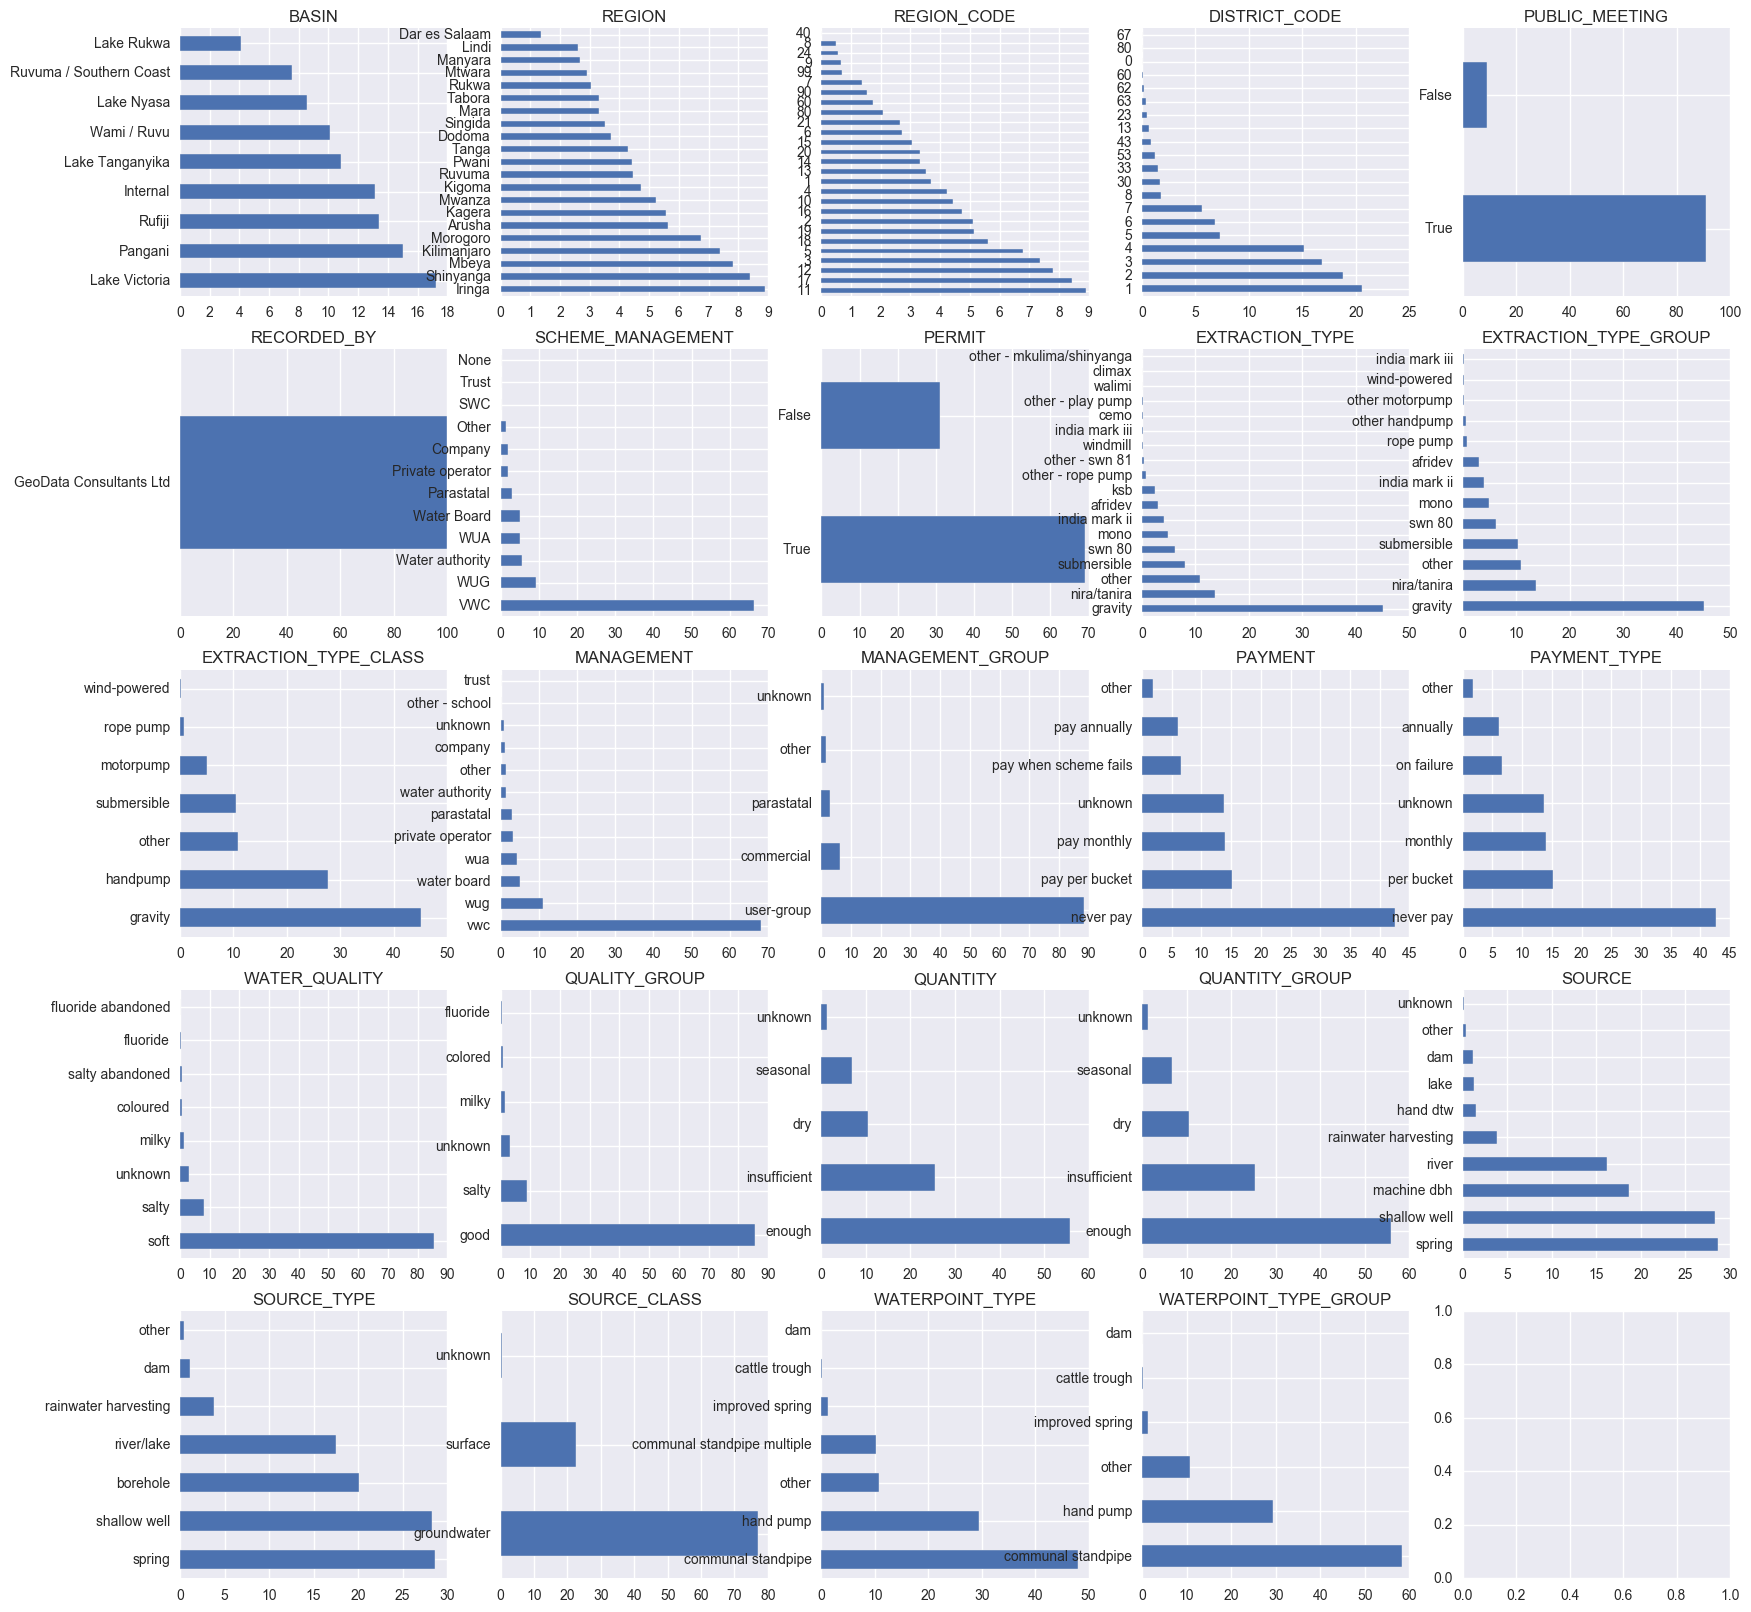

In [17]:
sam_dataframe_cols_value_count_analysis(RAW_X)

** Checking rest of the columns**

In [18]:
cols_value_count_limit_fraction = 0.01
cols_value_count_limit_log_value = np.log(RAW_X.shape[0] * cols_value_count_limit_fraction)


print('Total Number of Records:', RAW_X.shape[0], '- Log val is:', np.log(RAW_X.shape[0]))
print('%s percent of Number of Records:' % (cols_value_count_limit_fraction * 100),\
      RAW_X.shape[0] * cols_value_count_limit_fraction,\
      ' - Log val is:',  cols_value_count_limit_log_value)

Total Number of Records: 59400 - Log val is: 10.9920495054
1.0 percent of Number of Records: 594.0  - Log val is: 6.38687931936


### cols_categorical_check

Here in this project, `cols_categorical_check` refers to list of columns for which caution check is considered. Reason for this check is, we would need more data to explain other columns & target cols with respect to it.

Lets consider these columns with more 5% of values as non categorical values and since our problem statement is choosing which category, we will try to minimise the category and see how our performance changes(improves or not)

To begin we will consider that those categories with more than `cols_value_count_limit_fraction` percentage as the upper limit allowed. Any column with other data will pruged to become some to other information

In [19]:
show_object_dtypes(RAW_X, True)

date_recorded            object
funder                   object
installer                object
wpt_name                 object
basin                    object
subvillage               object
region                   object
lga                      object
ward                     object
public_meeting           object
recorded_by              object
scheme_management        object
scheme_name              object
permit                   object
extraction_type          object
extraction_type_group    object
extraction_type_class    object
management               object
management_group         object
payment                  object
payment_type             object
water_quality            object
quality_group            object
quantity                 object
quantity_group           object
source                   object
source_type              object
source_class             object
waterpoint_type          object
waterpoint_type_group    object
dtype: object

In [20]:
show_object_dtypes(RAW_X, False)

amount_tsh           float64
gps_height             int64
longitude            float64
latitude             float64
num_private            int64
region_code            int64
district_code          int64
population             int64
construction_year      int64
dtype: object

In [21]:
cols_non_categorical = show_object_dtypes(RAW_X, True).index.tolist()

cols_date_numerics = show_object_dtypes(RAW_X, True).index.tolist()

In [22]:
cols_categorical_check = []

for col, vc in cols_values_counts_dataframe.iterrows():
    if col in cols_non_categorical:
        if float(vc) > cols_value_count_limit_log_value:
            cols_categorical_check.append(col)

print('Columns we need to moderate are:', cols_categorical_check)

Columns we need to moderate are: ['funder', 'installer', 'wpt_name', 'subvillage', 'ward', 'scheme_name']


All `cols_date_numerics`, are date & other numeric data which can be made into buckets or reducing precision. Thus we can bound number of categories in data as the more variety of data we have, we need more information specific to each category which all might end with **curse of dimensionality**.

During pre-processing states we shall do following
TODO
* limiting check experiments on our **`cols_date_numerics`** & **`cols_categorical_check`** to be under **`cols_value_count_limit_fraction`**

In [23]:
print('Log limit for categories:', cols_value_count_limit_log_value)
print('Actual limit for categories:', cols_value_count_limit_fraction * RAW_X.shape[0])

RAW_X[cols_categorical_check].head()

Log limit for categories: 6.38687931936
Actual limit for categories: 594.0


,funder,installer,wpt_name,subvillage,ward,scheme_name
id,,,,,,
69572,Roman,Roman,none,Mnyusi B,Mundindi,Roman
8776,Grumeti,GRUMETI,Zahanati,Nyamara,Natta,NaN
34310,Lottery Club,World vision,Kwa Mahundi,Majengo,Ngorika,Nyumba ya mungu pipe scheme
67743,Unicef,UNICEF,Zahanati Ya Nanyumbu,Mahakamani,Nanyumbu,NaN
19728,Action In A,Artisan,Shuleni,Kyanyamisa,Nyakasimbi,NaN


In [24]:
RAW_X[cols_categorical_check].head(15)

,funder,installer,wpt_name,subvillage,ward,scheme_name
id,,,,,,
69572,Roman,Roman,none,Mnyusi B,Mundindi,Roman
8776,Grumeti,GRUMETI,Zahanati,Nyamara,Natta,NaN
34310,Lottery Club,World vision,Kwa Mahundi,Majengo,Ngorika,Nyumba ya mungu pipe scheme
67743,Unicef,UNICEF,Zahanati Ya Nanyumbu,Mahakamani,Nanyumbu,NaN
19728,Action In A,Artisan,Shuleni,Kyanyamisa,Nyakasimbi,NaN
9944,Mkinga Distric Coun,DWE,Tajiri,Moa/Mwereme,Moa,Zingibali
19816,Dwsp,DWSP,Kwa Ngomho,Ishinabulandi,Samuye,NaN
54551,Rwssp,DWE,Tushirikiane,Nyawishi Center,Chambo,NaN
53934,Wateraid,Water Aid,Kwa Ramadhan Musa,Imalauduki,Itetemia,NaN


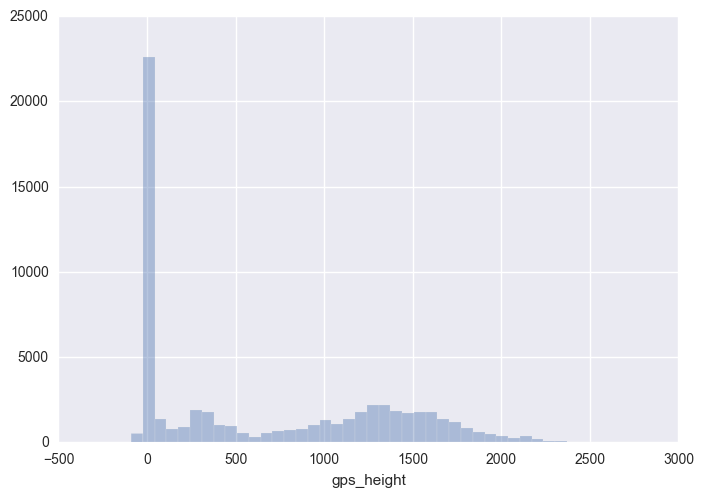

In [25]:
_ = sns.distplot(RAW_X.gps_height, hist=True, kde=False, rug=False)

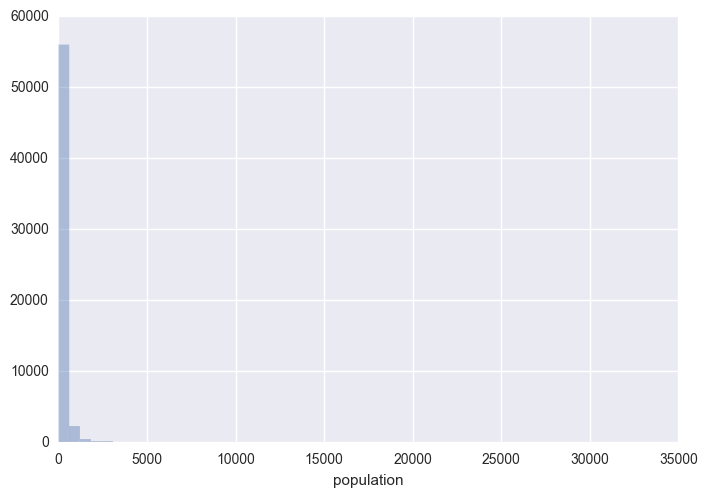

In [26]:
_ = sns.distplot(RAW_X.population, hist=True, kde=False, rug=False)

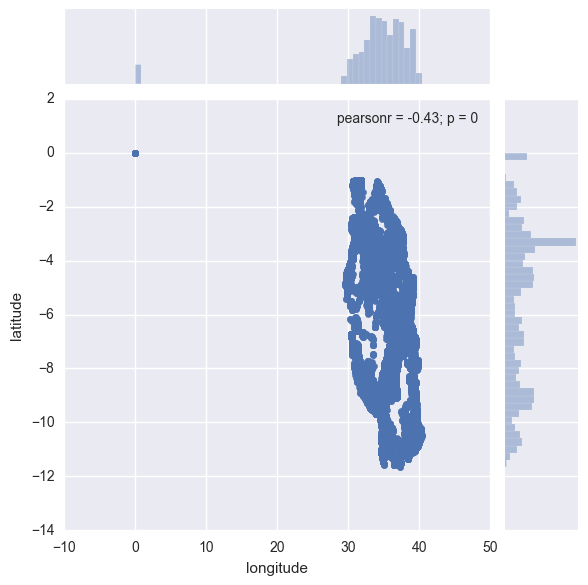

In [27]:
_ = sns.jointplot(x='longitude', y='latitude', data=RAW_X)

In [28]:
%%asmarkdown

# To generate a Markup Table
tmp = sam_dataframe_markup_value_counts(dataframe=RAW_X, max_print_value_counts=10, show_plots=False, figsize=(9, 2))

for each in tmp:
    print(each)

Col ID,Col Name,UniqCount,Col Values,UniqValCount
1,amount_tsh,98,,
2,date_recorded,356,,
3,funder,1897,,
4,gps_height,2428,,
5,installer,2145,,
6,longitude,57516,,
7,latitude,57517,,
8,wpt_name,37400,,
9,num_private,65,,
10,basin,9,Internal,7785


# Observations & TODO

* Most of the data seems categorical

* Need to check **cols_date_numerics**(TODO1)
    * we shall convert date -> day, month, year, weekday, total_no_of_day_from_reference_point. These splits for two reasons.
        * Reason1: It might be possible that in some location all specific set of complaints are registered on a start/mid/at end of the month. It might also be possible that they are registered on every Monday or so.
        * Reason2: Taking as much information as possible.
* Need to check **cols_categorical_check**(TODO2) 
    * longitutude & latitude seem to hold (0,0) instead of NULL which is acting as outlier for now

* Following pairs looks closesly related - cleanup (TODO3)
    * quantity & quantity_group
    * quality_group & water_quality
    * extraction_type, extraction_type_class & extraction_type_group

* Other - cleanup (TODO4)
    * recorded_by, seems to hold only a single value
    * population & amount_tsh, values are for some given as zero

# Data Processing

## Generic Transformations
** Num/Bool Tranformations **

* date_recorded to Int
* public_meeting to Int
* permit to Int
* longitude to Float(less precision)
* latitude to Float(less precision)

Precision Description of Longititude and Latitude is available here at below [link](http://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude)





In [31]:
# Reloading the data

RAW_X = pd.read_csv('data/traning_set_values.csv', index_col='id')
RAW_y = pd.read_csv('data/training_set_labels.csv', index_col='id')
RAW_TEST_X = pd.read_csv('data/test_set_values.csv', index_col='id')

### Int Transformations

In [32]:
import datetime

strptime = datetime.datetime.strptime

DATE_FORMAT = "%Y-%m-%d"
REFERENCE_DATE_POINT = strptime('2000-01-01', DATE_FORMAT)

if RAW_X.date_recorded.dtype == 'O':

    # convert it to datetime format
    f = lambda x: strptime(str(x), DATE_FORMAT)
    RAW_X.date_recorded = RAW_X.date_recorded.apply(f)
    RAW_TEST_X.date_recorded = RAW_TEST_X.date_recorded.apply(f)

    # week day
    f = lambda x: x.weekday()
    RAW_X['date_recorded_weekday'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_weekday'] = RAW_TEST_X.date_recorded.apply(f)

    # date
    f = lambda x: x.day
    RAW_X['date_recorded_date'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_date'] = RAW_TEST_X.date_recorded.apply(f)

    # month
    f = lambda x: x.month
    RAW_X['date_recorded_month'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_month'] = RAW_TEST_X.date_recorded.apply(f)

    # year
    f = lambda x: x.year
    RAW_X['date_recorded_year'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_year'] = RAW_TEST_X.date_recorded.apply(f)

    # total days
    f = lambda x: (x - REFERENCE_DATE_POINT).days
    RAW_X.date_recorded = RAW_X.date_recorded.apply(f)
    RAW_TEST_X.date_recorded = RAW_TEST_X.date_recorded.apply(f)

In [33]:
# Longitude & Latitude -- zero values fix

# Filling Missing/OUTLIAR Values
_ = np.mean(RAW_X[u'latitude'][RAW_X.latitude < -1.0].values)

if not RAW_X.loc[RAW_X.latitude >= -1.0, u'latitude'].empty:
    RAW_X.loc[RAW_X.latitude >= -1.0, u'latitude'] = _
    RAW_TEST_X.loc[RAW_TEST_X.latitude >= -1.0, u'latitude'] = _


# Filling Missing/OUTLIAR Values
_ = np.mean(RAW_X[u'longitude'][RAW_X[u'longitude'] > 1.0].values)

if not RAW_X.loc[RAW_X[u'longitude'] <= 1.0, u'longitude'].empty:
    RAW_X.loc[RAW_X[u'longitude'] <= 1.0, u'longitude'] = _
    RAW_TEST_X.loc[RAW_TEST_X[u'longitude'] <= 1.0, u'longitude'] = _

In [34]:
def f(x):
    if x is True:
        return 1
    elif x is False:
        return 2
    else:
        return 3


if (RAW_X.public_meeting.dtype != 'bool') and (RAW_X.permit.dtype != 'bool'):

    # public_meeting
    RAW_X.public_meeting = RAW_X.public_meeting.apply(f)
    RAW_TEST_X.public_meeting = RAW_TEST_X.public_meeting.apply(f)

    # permit
    RAW_X.permit = RAW_X.permit.apply(f)
    RAW_TEST_X.permit = RAW_TEST_X.permit.apply(f)

print('Dtype of public_meetings & permit:',RAW_X.public_meeting.dtype, RAW_X.permit.dtype)
print('')
# checking
if list(RAW_TEST_X.dtypes[RAW_TEST_X.dtypes != RAW_X.dtypes]):
    raise Exception('RAW_X.dtypes and RAW_TEST_X.dtypes are not in Sync')
else:
    print('All in Good Shape')

Dtype of public_meetings & permit: int64 int64

All in Good Shape


In [35]:
show_object_dtypes(RAW_X, True)

funder                   object
installer                object
wpt_name                 object
basin                    object
subvillage               object
region                   object
lga                      object
ward                     object
recorded_by              object
scheme_management        object
scheme_name              object
extraction_type          object
extraction_type_group    object
extraction_type_class    object
management               object
management_group         object
payment                  object
payment_type             object
water_quality            object
quality_group            object
quantity                 object
quantity_group           object
source                   object
source_type              object
source_class             object
waterpoint_type          object
waterpoint_type_group    object
dtype: object

In [37]:
show_object_dtypes(RAW_X, False)

amount_tsh               float64
date_recorded              int64
gps_height                 int64
longitude                float64
latitude                 float64
num_private                int64
region_code                int64
district_code              int64
population                 int64
public_meeting             int64
permit                     int64
construction_year          int64
date_recorded_weekday      int64
date_recorded_date         int64
date_recorded_month        int64
date_recorded_year         int64
dtype: object

In [38]:
# Reducing geo location precision to 11 meters
LONG_LAT_PRECISION = 0.001

# Reducing Precision of Lat.
if RAW_X.longitude.mean() < 50:
    RAW_X.longitude = RAW_X.longitude // LONG_LAT_PRECISION
    RAW_X.latitude = RAW_X.latitude // LONG_LAT_PRECISION
    RAW_TEST_X.longitude = RAW_TEST_X.longitude // LONG_LAT_PRECISION
    RAW_TEST_X.latitude = RAW_TEST_X.latitude // LONG_LAT_PRECISION

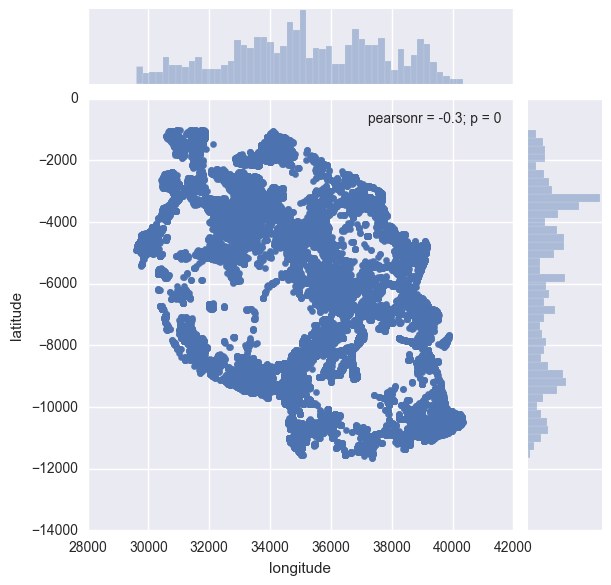

In [39]:
_ = sns.jointplot(x='longitude', y='latitude', data=RAW_X)

### Text Data Tranformations

For **cols_categorical_check**, we are going to basic clean action like, lower and upper case issue. Clearning of non ascii values.

In [40]:
def text_transformation(name):
    if name:
        name = name.lower().strip()
        name = ''.join([i if 96 < ord(i) < 128 else ' ' for i in name])
        if 'and' in name:
            name = name.replace('and', ' ')
        if '/' in name:
            name = name.replace('/', ' ')
        while '  ' in name:
            name = name.replace('  ', ' ')
        return name.strip()
    return ''

In [41]:
%%asmarkdown

print('''
|Column|Prev.|Current|
|------|-----|-------|''')
for col in cols_categorical_check:
    aa = len(RAW_X[col].unique())
    RAW_X[col] = RAW_X[col].fillna('').apply(text_transformation)
    RAW_TEST_X[col] = RAW_TEST_X[col].fillna('').apply(text_transformation)
    bb = len(RAW_X[col].unique())
    if aa != bb:
        print('|%s|%i|%i|' % (col, aa, bb))

Column,Prev.,Current
funder,1898,1880
installer,2146,1866
wpt_name,37400,36717
subvillage,19288,19175
scheme_name,2697,2485


In [51]:
# saving transformed data
pickle.dump(obj=RAW_X, file=open('tmp\clean_X.pkl', 'wb'))
pickle.dump(RAW_TEST_X, open('tmp\clean_TEST_X.pkl', 'wb'))
# pickle.dump(y, open('tmp\y.pkl', 'wb'))

TEST_X, X = RAW_TEST_X, RAW_X

## Custom Labeler

Loading Custom Labeler is for the the purpose of reducing categories varieties by ignoring groups with lower frequencies and covering 80%(default) of the original data.

In [60]:
from collections import defaultdict
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from scripts import sam_custom_labeler

CUST_CATEGORY_LABELER = sam_custom_labeler.CUST_CATEGORY_LABELER

In [61]:
help(CUST_CATEGORY_LABELER)

Help on class CUST_CATEGORY_LABELER in module scripts.sam_custom_labeler:

class CUST_CATEGORY_LABELER(builtins.object)
 |  Custom Mapper Function.
 |  
 |  Based on pd.Series.values_counts, a labler is prepared
 |   to cover one of following details
 |      1. cover top 80% of groups(DEFAULT) (or)
 |      2. top 500 groups
 |  
 |  A special `transform_analysis` function is provided to
 |   understand how value_counts are spread out
 |  
 |  Example:
 |      >>> # Test Data
 |      >>> ss = pd.Series(np.arange(5000) // 5)
 |      >>> ss = ss.map(lambda x: str(x))
 |      >>>
 |      >>> # creating labler
 |      >>> labler = CUST_CATEGORY_LABELER()
 |      >>> labler.fit(funder)
 |      >>>
 |      >>> # testing
 |      >>> _ =  labler.check_group_coverage(90)
 |      90 percentage of GROUPS coverage mean, 1691(in number) groups
 |      >>>
 |      >>> _ =  labler.check_data_coverage(90)
 |      90 percentage of DATA coverage mean, 666 (in number) groups
 |  
 |  Methods defined here:

In [62]:
labler = CUST_CATEGORY_LABELER()

def select_col(col):
    global labler
    labler = CUST_CATEGORY_LABELER()
    labler.fit(RAW_TEST_X[col])
    print('Selected', col)

ii = interact(select_col, col=['funder', 'installer', 'wpt_name', 'subvillage', 'ward', 'scheme_name'])

# To check data coverage
def f1(data=80):
    labler.check_data_coverage(data_coverage=data)

ii1 = interact(f1, data=(70, 100, .5))

# To check groups coverage
def f2(groups=80):
    labler.check_group_coverage(groups)
    
ii2 = interact(f2, groups=(50, 100., .5))

_ = '''
Please select one of these slider to chose among the
 data coverage or groups coverage
'''

80.0 percentage of GROUPS coverage mean, 777.6(in number) groups


* funder:
    * 100.0 percentage of DATA coverage mean, 1881 (in number) groups
    * 97.0 percentage of DATA coverage mean, 592 (in number) groups ##
    * 90.5 percentage of DATA coverage mean, 237 (in number) groups
* installer:
    * 100.0 percentage of DATA coverage mean, 1867 (in number) groups
    * 97.0 percentage of DATA coverage mean, 599 (in number) groups ##

* wpt_name:
    * 80.0 percentage of DATA coverage mean, 24838 (in number) groups ##

* subvillage:
    * 80.5 percentage of DATA coverage mean, 8715 (in number) groups ##
    * 83.0 percentage of DATA coverage mean, 9458 (in number) groups
* ward:
    * 80.0 percentage of DATA coverage mean, 998 (in number) groups ##
    * 91.5 percentage of DATA coverage mean, 1397 (in number) groups
    * 100.0 percentage of DATA coverage mean, 2093 (in number) groups
* scheme_name:
    * 100.0 percentage of DATA coverage mean, 2486 (in number) groups
    * 91.5 percentage of DATA coverage mean, 870 (in number) groups
    * 80.5 percentage of DATA coverage mean, 363 (in number) groups
    * 85.0 percentage of DATA coverage mean, 524 (in number) groups ##    
** NOTE **:
    Marked with double hashes are the selected values for coverage


In [63]:
##################################
######### TESTING ################
#################################

labler = CUST_CATEGORY_LABELER()
labler.fit(X.installer)

# default data coverage is 80
tmp = labler.transform()

print('data coveraged', labler.DATA_COVERAGE_LIMIT)
print('grous coveraged', len(tmp.value_counts()))

print('---------------------')
labler.DATA_COVERAGE_LIMIT = 90
tmp = labler.transform()

print('data coveraged', labler.DATA_COVERAGE_LIMIT)
print('grous coveraged', len(tmp.value_counts()))


80 percentage of DATA coverage mean, 81 (in number) groups
data coveraged 80
grous coveraged 82
---------------------
90 percentage of DATA coverage mean, 203 (in number) groups
data coveraged 90
grous coveraged 204


In [65]:
##################################
######### IMPLEMENT ##############
#################################

if 'custom_labler' not in dir():
    custom_labler = defaultdict(CUST_CATEGORY_LABELER)
    tmp = { 'funder': 97,
      'installer': 97,
      'wpt_name': 80,
      'subvillage': 80,
      'ward': 80,
      'scheme_name': 85
      }

    for col, limit  in tmp.items():
        labler = custom_labler[col]
        labler.DATA_COVERAGE_LIMIT = limit
        labler.fit(X[col])
        print('')
        print('-' * 15, col.upper())

    #     custom_labler[col].check_data_coverage(limit)
        RAW_X[col] = labler.transform()
else:
    print('"custom_labler" seems is already defined, please check')
    
print(RAW_X.shape, RAW_TEST_X.shape, all(RAW_X.columns == RAW_TEST_X.columns))

"custom_labler" seems is already defined, please check
(59400, 43) (14850, 43) True


## Label Encoder

Label Encoder with DefaultDict for quick data transformation
http://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

In [66]:
from collections import defaultdict
from sklearn import preprocessing

In [67]:
print(RAW_X.shape, RAW_TEST_X.shape)

(59400, 43) (14850, 43)


In [90]:
d = defaultdict(preprocessing.LabelEncoder)

RAW_X.scheme_management = RAW_X.scheme_management.fillna('Other')
RAW_TEST_X.scheme_management = RAW_TEST_X.scheme_management.fillna('Other')

# Labels Fit
sam = pd.concat([RAW_X, RAW_TEST_X]).apply(lambda x: d[x.name].fit(x))

# Labels Transform - Training Data
X = RAW_X.apply(lambda x: d[x.name].transform(x))
TEST_X = RAW_TEST_X.apply(lambda x: d[x.name].transform(x))

le = preprocessing.LabelEncoder().fit(RAW_y[u'status_group'])
y = le.transform(RAW_y[u'status_group'])

In [91]:
show_object_dtypes(RAW_X, True)

funder                   object
installer                object
wpt_name                 object
basin                    object
subvillage               object
region                   object
lga                      object
ward                     object
recorded_by              object
scheme_management        object
scheme_name              object
extraction_type          object
extraction_type_group    object
extraction_type_class    object
management               object
management_group         object
payment                  object
payment_type             object
water_quality            object
quality_group            object
quantity                 object
quantity_group           object
source                   object
source_type              object
source_class             object
waterpoint_type          object
waterpoint_type_group    object
dtype: object

In [92]:
show_object_dtypes(X, True)

Series([], dtype: object)

## Pickle

** Pickle Save **

In [93]:
# saving transformed data
pickle.dump(X, open('tmp\processed_X.pkl', 'wb'))
pickle.dump(TEST_X, open('tmp\processed_TEST_X.pkl', 'wb'))
pickle.dump(y, open('tmp\processed_y.pkl', 'wb'))

# saving label transformers
pickle.dump(d, open('tmp\d.pkl', 'wb'))
pickle.dump(le, open('tmp\le.pkl', 'wb'))

# Feature Selection


### Variance Threshold

To remove all features that are either one or zero (on or off) in more than 80% of the samples.

http://scikit-learn.org/stable/modules/feature_selection.html#removing-features-with-low-variance

http://stackoverflow.com/questions/29298973/removing-features-with-low-variance-scikit-learn/34850639#34850639

In [95]:
X = pickle.load(open('tmp\processed_X.pkl', 'rb'))
TEST_X = pickle.load(open('tmp\processed_TEST_X.pkl', 'rb'))
y = pickle.load(open('tmp\processed_y.pkl', 'rb'))

# # Load this when you are about to do text transformation and submission
# d = pickle.load(open('tmp\d.pkl'))
# le = pickle.load(open('tmp\le.pkl'))

print(X.shape, y.shape, y[:5])

(59400, 43) (59400,) [0 0 0 2 0]


In [96]:
from scripts.sam_variance_check import get_low_variance_columns

In [97]:
X, removed_features, ranking_variance_thresholds = get_low_variance_columns(dframe=X,
                                                                            threshold=(0.85 * (1 - 0.85)),
                                                                            autoremove=True)

print('\nLow Variance Columns', removed_features)
print('Shape of X is', X.shape)

Finding low-variance features.
Found 1 low-variance columns.
                
Removing low-variance features.
Reassembling the dataframe (with low-variance features removed).
Succesfully removed low-variance columns.

Low Variance Columns ['recorded_by']
Shape of X is (59400, 42)


In [98]:
if removed_features:
    TEST_X.drop(removed_features, axis=1, inplace=True)
    print('cleanup completed!')

cleanup completed!


In [99]:
print('Shape of X is', X.shape)
print('Shape of TEST_X is', TEST_X.shape)

Shape of X is (59400, 42)
Shape of TEST_X is (14850, 42)


### Select K Best

* For regression: f_regression, mutual_info_regression
* For classification: chi2, f_classif, mutual_info_classif


Random Forest Classifier score: RandomForestClassifier(n_estimators=150, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1)
* chi2 0.81225589225589223
*  f_classic 0.81138047138047142
* mutual_info_classif 0.81037037037037041

In [100]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def game(X, y):
#     print(X.shape, y.shape[0])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    clf_rf = RandomForestClassifier(n_jobs=-1, random_state=192)
    clf_rf = clf_rf.fit(X_train, y_train)
    
    train_score = clf_rf.score(X_train, y_train)
    test_score = clf_rf.score(X_test, y_test)
#     print('Train Score', train_score)
#     print('Test  Score', test_score)
    return train_score, test_score

** kbest conclusion **:

Best selected columns
```
AMOUNT_TSH, DATE_RECORDED, FUNDER, GPS_HEIGHT, INSTALLER, LONGITUDE, LATITUDE, NUM_PRIVATE, BASIN, SUBVILLAGE, REGION, REGION_CODE, DISTRICT_CODE, LGA, WARD, POPULATION, PUBLIC_MEETING, SCHEME_MANAGEMENT, SCHEME_NAME, PERMIT, CONSTRUCTION_YEAR, EXTRACTION_TYPE, EXTRACTION_TYPE_GROUP, EXTRACTION_TYPE_CLASS, MANAGEMENT, MANAGEMENT_GROUP, PAYMENT, PAYMENT_TYPE
```

``` Python
# results of previous runs
[{'cols': 1, 'test': 0.52659932659932662, 'train': 0.57483726150392822},
 {'cols': 5, 'test': 0.68962962962962959, 'train': 0.94240179573512906},
 {'cols': 9, 'test': 0.7211447811447812, 'train': 0.97638608305274976},
 {'cols': 13, 'test': 0.75380471380471381, 'train': 0.97955106621773291},
 {'cols': 17, 'test': 0.76134680134680133, 'train': 0.98071829405162736},
 {'cols': 21, 'test': 0.76511784511784509, 'train': 0.98076318742985413},
 {'cols': 25, 'test': 0.80033670033670035, 'train': 0.98316498316498313},
 {'cols': 29, 'test': 0.80053872053872055, 'train': 0.98379349046015707},
 {'cols': 33, 'test': 0.80040404040404045, 'train': 0.98390572390572395},
 {'cols': 37, 'test': 0.79993265993265994, 'train': 0.98341189674523011}]

[{'cols': 23, 'test': 0.7976430976430976, 'train': 0.9836812570145903},
 {'cols': 25, 'test': 0.80033670033670035, 'train': 0.98316498316498313},
 {'cols': 27, 'test': 0.80101010101010106, 'train': 0.9829405162738496},
 {'cols': 29, 'test': 0.80053872053872055, 'train': 0.98379349046015707},
 {'cols': 31, 'test': 0.80000000000000004, 'train': 0.98381593714927051}]

[{'cols': 26, 'test': 0.80309764309764309, 'train': 0.98359147025813698},
 {'cols': 27, 'test': 0.80101010101010106, 'train': 0.9829405162738496},
 {'cols': 28, 'test': 0.80222222222222217, 'train': 0.98334455667789}]
```


As per Okham Razor's rules, we are going to select the simplest and well performing. Luckily, we have got kbest_selected_cols at **26** which is comparitively top performer among other K-selections and also lower than actualy number of columns


In [102]:
kbest_cols = 26

fit = SelectKBest(score_func=chi2, k=kbest_cols).fit(X, y)
cols_names = X.columns
kbest_selected_cols =  [_ for _ in cols_names[:kbest_cols]]

kbest_X = pd.DataFrame(fit.transform(X))
kbest_TEST_X = pd.DataFrame(fit.transform(TEST_X))

In [103]:
pickle.dump(kbest_X, open('tmp\kbest_X.pkl', 'wb'))
pickle.dump(kbest_TEST_X, open('tmp\kbest_TEST_X.pkl', 'wb'))
pickle.dump(y, open('tmp\kbest_y.pkl', 'wb'))

### PCA

In [105]:
if True:
    # this will load kbest
    print('Loading KBest Processed Data')
    X = pickle.load(open('tmp\kbest_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\kbest_TEST_X.pkl', 'rb'))
    y = pickle.load(open('tmp\kbest_y.pkl', 'rb'))
else:
    # this will load processed data
    print('Loading normal Processed Data')
    X = pickle.load(open('tmp\processed_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\processed_TEST_X.pkl', 'rb'))

# # y = pickle.load(open('tmp\processed_y.pkl'))

Loading KBest Processed Data


** PCA **

In [106]:
from sklearn.decomposition import PCA

[ 0.79029416  0.93691792  0.9718267   0.99050439]


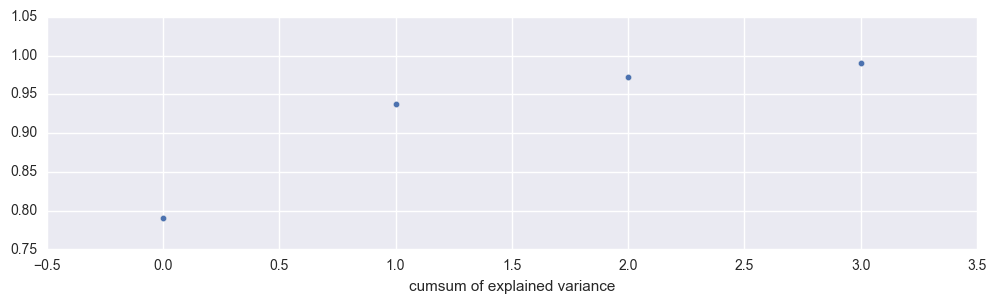

In [107]:
# feature extraction
pca = PCA(n_components=4)
fit = pca.fit(X)

plt.figure(figsize=(12, 3))

_ = plt.scatter (range(len(fit.explained_variance_ratio_)), fit.explained_variance_ratio_.cumsum())

_ = plt.xlabel('cumsum of explained variance')

print(fit.explained_variance_ratio_.cumsum())

In [108]:
X = pca.transform(X)
TEST_X = pca.transform(TEST_X)

In [109]:
X.shape, TEST_X.shape

((59400, 4), (14850, 4))

** Saving Processed Data **

In [110]:
pickle.dump(X, open('tmp\pca_X.pkl', 'wb'))
pickle.dump(TEST_X, open('tmp\pca_TEST_X.pkl', 'wb'))
# pickle.dump(y, open('tmp\pca_y.pkl', 'wb'))

# Unsupervised Learning

* Unsupervised Learning Exploration(Gaussian Process, Neural Nets)

** Loading Pre-Processed Data **

In [112]:
load = 1

if load == 1:
    print('Loading PCA Processed Data')
    X = pickle.load(open('tmp\pca_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\pca_TEST_X.pkl', 'rb'))

elif load == 2:
    # this will load kbest
    print('Loading KBest Processed Data')
    X = pickle.load(open('tmp\kbest_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\kbest_TEST_X.pkl', 'rb'))
elif load == 3:
    # this will load processed data
    print('Loading normal Processed Data')
    X = pickle.load(open('tmp\processed_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\processed_TEST_X.pkl', 'rb'))

# # y = pickle.load(open('tmp\processed_y.pkl'))

Loading PCA Processed Data


In [113]:
print(X.shape, y.shape, TEST_X.shape)

(59400, 4) (59400,) (14850, 4)


### Gaussian

In [114]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score

In [115]:
# For future analysis
GMM_Centers = []

__check_for  = 1000

for i in range(2, 7):
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = GMM(n_components=i, random_state=42)
    clusterer.fit(X)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(X)

    # TODO: Find the cluster centers
    GMM_Centers.append(clusterer.means_)

    # score = silhouette_score(X, preds)
    score = silhouette_score(X[:__check_for], preds[:__check_for])

    print(i, score)

2 0.484879234998
3 0.377180934294
4 0.334333476259
5 0.29213724894
6 0.27643712696


### KMeans

In [116]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [117]:
# For future analysis
KMM_Centers = []

# Testing each category
for i in range(2, 7):

    clusterer = KMeans(init='k-means++', n_clusters=i, n_init=10)
    clusterer.fit(X)

    preds = clusterer.predict(X)

    centers = clusterer.cluster_centers_
    
    KMM_Centers.append(centers)

#     score = silhouette_score(X, preds)
    score = silhouette_score(X[:__check_for], preds[:__check_for])
    print(i, score)

2 0.502005229628
3 0.377168744959
4 0.325091546516
5 0.303811069492
6 0.304265445159


In [118]:
i = 2

clusterer = KMeans(init='k-means++', n_clusters=i, n_init=10)
clusterer.fit(X)
preds = clusterer.predict(X)

In [119]:
score = silhouette_score(X[:__check_for], preds[:__check_for])
print(i, score)

2 0.502005229628


In [120]:
print(X.shape, TEST_X.shape)

(59400, 4) (14850, 4)


In [121]:
X = pd.DataFrame(X)
X['new'] = clusterer.predict(X)

In [122]:
TEST_X = pd.DataFrame(TEST_X)
TEST_X['new'] = clusterer.predict(TEST_X)

In [123]:
print(X.shape, TEST_X.shape)

(59400, 5) (14850, 5)


# Supervised Learning

* Supervised Learning(GBT Trees, Nearest Neighbours, RF, One-vs-One)

### Test-Train Split

In [124]:
from sklearn.model_selection import train_test_split

load = 3

if load == 1:
    print('Loading PCA Processed Data')
    X = pickle.load(open('tmp\pca_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\pca_TEST_X.pkl', 'rb'))

elif load == 2:
    # this will load kbest
    print('Loading KBest Processed Data')
    X = pickle.load(open('tmp\kbest_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\kbest_TEST_X.pkl', 'rb'))
elif load == 3:
    # this will load processed data
    print('Loading normal Processed Data')
    X = pickle.load(open('tmp\processed_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\processed_TEST_X.pkl', 'rb'))

y = pickle.load(open('tmp\processed_y.pkl', 'rb'))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(X.shape, y.shape)

Loading normal Processed Data
(59400, 43) (59400,)


### GBT Trees

In [125]:
from sklearn.ensemble import GradientBoostingClassifier

In [126]:
clf_gbt = GradientBoostingClassifier(random_state=192)

clf_gbt = clf_gbt.fit(X_train, y_train)

print('score:', clf_gbt.score(X_test, y_test))

# ('score:', 0.75252525252525249) k_best score

# ('score:', 0.75400673400673401) preprocessed

score: 0.755757575758


### Nearest Neighbours

In [127]:
from sklearn.neighbors import KNeighborsClassifier

In [128]:
# modelling
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_test, y_test)

# score
clf_knn.score(X_train, y_train)

# 0.55842873176206509 k_best
# 0.55840628507295176 preprocessed

0.55551066217732881

### Random Forest

In [129]:
from sklearn.ensemble import RandomForestClassifier

In [130]:
clf_rf = RandomForestClassifier(random_state=192)
clf_rf = clf_rf.fit(X_train, y_train)

print('Score:' + str(clf_rf.score(X_test, y_test)))

# 0.79542087542087547 # (n_jobs=-1, random_state=192)
# 0.800942760943 k_best
# 0.8

Score:0.802356902357


In [131]:
print(list(zip(X.columns, clf_rf.feature_importances_)))

[('amount_tsh', 0.017809585685662929), ('date_recorded', 0.033169796379169343), ('funder', 0.02882827281745317), ('gps_height', 0.039991413100463398), ('installer', 0.021453998802411219), ('longitude', 0.07166028830036833), ('latitude', 0.068875419554731143), ('wpt_name', 0.054416869786483447), ('num_private', 0.00099687377203183831), ('basin', 0.011094360505021977), ('subvillage', 0.049976411476797669), ('region', 0.013387272218786944), ('region_code', 0.014914965014701933), ('district_code', 0.011467169829740368), ('lga', 0.020812712586561751), ('ward', 0.03036113156523898), ('population', 0.031195428301793039), ('public_meeting', 0.0055197208486220594), ('recorded_by', 0.0), ('scheme_management', 0.010815317149700687), ('scheme_name', 0.02013836570759317), ('permit', 0.0062459804438934948), ('construction_year', 0.03175039022074886), ('extraction_type', 0.012391926746021182), ('extraction_type_group', 0.014674972944704504), ('extraction_type_class', 0.021120968067940598), ('manageme

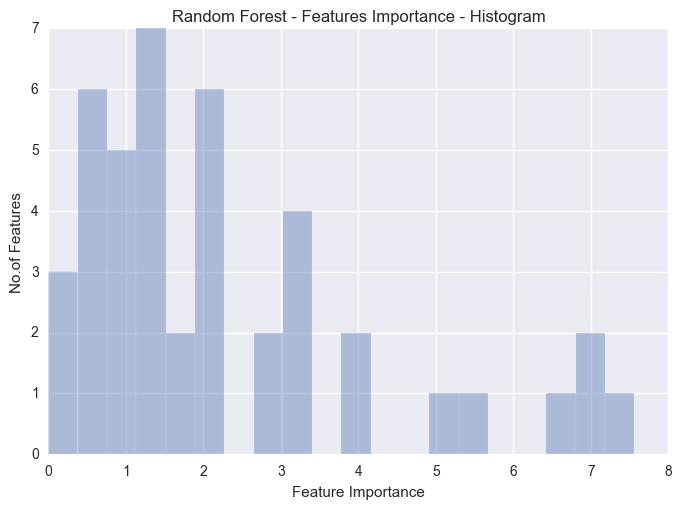

In [132]:
plt.title('Random Forest - Features Importance - Histogram')
plt.ylabel('No.of Features')
plt.xlabel('Feature Importance')

_ = sns.distplot(clf_rf.feature_importances_ * 100, bins=20, hist=True, kde=False)

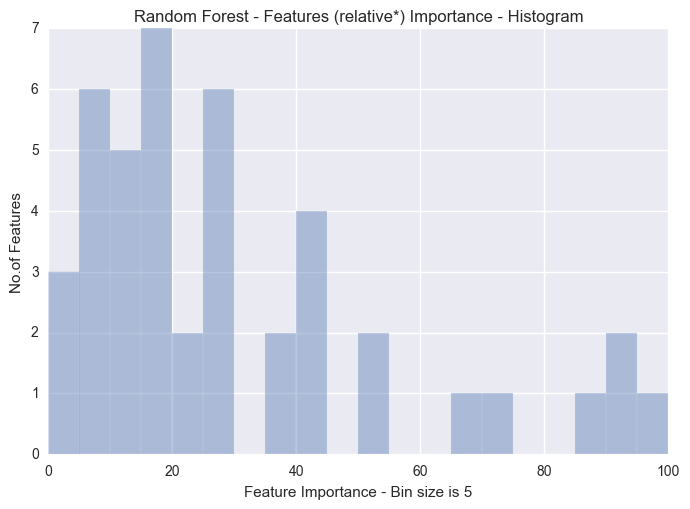

In [133]:
plt.title('Random Forest - Features (relative*) Importance - Histogram')
plt.ylabel('No.of Features')
plt.xlabel('Feature Importance - Bin size is 5')

tmp = 100 * (clf_rf.feature_importances_  - min(clf_rf.feature_importances_)) / max(clf_rf.feature_importances_)

_ = sns.distplot(tmp, bins=20, hist=True, kde=False)

In [134]:
bag = []
kbest_selected_cols = []
for col, score in zip(X.columns, tmp):
    if score < 5:
        bag.append(col)
    else:
        kbest_selected_cols.append(col)

print('Removed Cols:', bag)
print('Rest of Cols', kbest_selected_cols)

Removed Cols: ['num_private', 'recorded_by', 'date_recorded_year']
Rest of Cols ['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'date_recorded_weekday', 'date_recorded_date', 'date_recorded_month']


In [145]:
X[kbest_selected_cols].size / 40., X[kbest_selected_cols].shape

(59400.0, (59400, 40))

In [150]:

# n_estimators=150, criterion='entropy', class_weight="balanced_subsample", 

clf_rf = RandomForestClassifier(random_state=192, n_jobs=-1)
# class_weight="balanced_subsample"/"balanced"
# criterion="gini"/"entropy"

clf_rf = clf_rf.fit(X_train[kbest_selected_cols], y_train)
# pred = clf_rf.predict_proba(X_test)
clf_rf.score(X_test[kbest_selected_cols], y_test)

0.79946127946127943

### Multi Class

In [151]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

** One Vs One **

In [152]:
clf_multiclass_rf = OneVsOneClassifier(RandomForestClassifier(n_estimators=200,
                                                        criterion='entropy',
#                                                         class_weight="balanced_subsample",
                                                        n_jobs=-1))

# 0.81265993265993264

In [153]:
clf_multiclass_rf = clf_multiclass_rf.fit(X_train, y_train)

print('Classifier:', clf_multiclass_rf)

print('Score:', clf_multiclass_rf.score(X_train, y_train))
print('Score:', clf_multiclass_rf.score(X_test, y_test))

Classifier: OneVsOneClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
          n_jobs=1)
Score: 0.999820426487
Score: 0.814410774411


** One vs Rest **

In [154]:
clf_multiclass_rf = OneVsRestClassifier(RandomForestClassifier(random_state=192))

clf_multiclass_rf = clf_multiclass_rf.fit(X_train, y_train)

print('Classifier:', clf_multiclass_rf)
print('Train Score: ', clf_multiclass_rf.score(X_train, y_train))
print('Test Score:', clf_multiclass_rf.score(X_test, y_test))

Classifier: OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=192,
            verbose=0, warm_start=False),
          n_jobs=1)
Train Score:  0.990774410774
Test Score: 0.80101010101


In [155]:
clf_rf.random_state

192

## Parameter tuning


From above analysis we can see that Random Forest CLF performed better than most other and so here we shall optimise it.

In [156]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [157]:
# max_features
np.sqrt(len(X_train.columns)), np.log(len(X_train.columns))

(6.5574385243020004, 3.7612001156935624)

In [158]:
np.log2(len(X_train.columns)), np.sqrt (len(X_train.columns)), len(X_train.columns)

(5.4262647547020979, 6.5574385243020004, 43)

In [159]:
'balanced_subsample balanced'.split(), 'gini entropy'.split()

(['balanced_subsample', 'balanced'], ['gini', 'entropy'])

In [160]:
parameters = {
    'n_estimators': [10, 50, 100, 150, 200],
    'class_weight': ['balanced_subsample', 'balanced'],
    'criterion': ['gini', 'entropy'],
    'max_features': ['log2', 'auto', 25],
    'random_state': [192]
}

# clf_rf = RandomForestClassifier(n_estimators=150, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1, random_state=192)
# 0.81346801346801345

GS_CV = RandomizedSearchCV(RandomForestClassifier(), parameters)

GS_CV.fit(X, y)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'class_weight': ['balanced_subsample', 'balanced'], 'random_state': [192], 'criterion': ['gini', 'entropy'], 'max_features': ['log2', 'auto', 25], 'n_estimators': [10, 50, 100, 150, 200]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [161]:
print(GS_CV.best_params_, GS_CV.best_score_)
# {'n_estimators': 200, 'max_features': 'log2', 'random_state': 192, 'criterion': 'entropy',
#  'class_weight': 'balanced_subsample'} 0.806717171717

{'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'random_state': 192, 'max_features': 'auto', 'n_estimators': 200} 0.808181818182


In [162]:
cv_results = pd.DataFrame(GS_CV.cv_results_, columns=[u'mean_fit_time', u'mean_score_time', u'mean_test_score',
       u'mean_train_score', u'param_class_weight', u'param_criterion',
       u'param_max_features', u'param_n_estimators', u'params'])

In [163]:
cv_results.head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_class_weight,param_criterion,param_max_features,param_n_estimators,params
0,13.315984,0.964443,0.806970,0.999832,balanced,gini,auto,150,"{'criterion': 'gini', 'class_weight': 'balance..."
1,1.206220,0.067874,0.795152,0.984773,balanced,entropy,auto,10,"{'criterion': 'entropy', 'class_weight': 'bala..."


In [164]:
import seaborn as sns
sns.set(color_codes=True)

np.random.seed(sum(map(ord, "regression")))
tips = sns.load_dataset("tips")

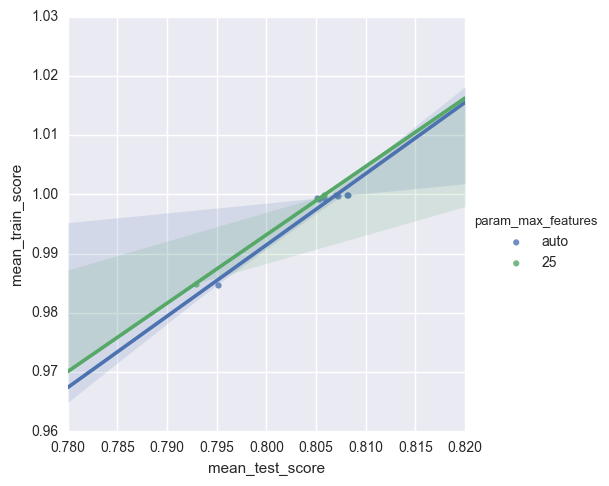

In [165]:
ax=plt.figure(figsize=(8,8))
_ = sns.lmplot(x="mean_test_score", y="mean_train_score", hue="param_max_features", data=cv_results)


* Checking "clf_rf" RF performance

## XGBOOST

# Submission

**Model Selection**

+ Check for which model is performing best and using it.
+ Check to apply the one-vs-many//one-vs-one wrapper.
+ Check for 'test_train_split' for which X,y to be used for training